# Solution

## Goal
Confidence intervals for the **mean** have clean textbook formulas. For the **median**, a practical default is the **bootstrap percentile confidence interval**: resample the data many times, compute the median each time, then take the desired percentiles of those medians.

## What you’ll do here
- Explain why median-based inference is different from mean-based inference.
- Build a 95% bootstrap confidence interval for the median.
- Visualize the bootstrap sampling distribution and interpret the interval.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

## Problem Statement
How would you get a (say) **95% confidence interval** for the **median** of a dataset?

### Why the median needs a different mindset
The mean often gets a normal-approximation story via the Central Limit Theorem, which leads to familiar closed-form intervals. The median is **more robust** (great for skew/outliers) but usually doesn’t come with a simple, universal analytic CI in real-world settings.

In practice (product analytics, ops, revenue, latency metrics), medians and quantiles are everywhere—so you want a method that works reliably when distributions are messy.

## Bootstrap percentile CI for the median (the practical default)
At a high level:

- **Resample with replacement**: from your $n$ observations, sample $n$ values *with replacement* to create one bootstrap sample.
- **Compute the statistic**: compute the median of that bootstrap sample.
- **Repeat**: do this many times (often 1,000–10,000).
- **Read off percentiles**: for a 95% CI, take the 2.5th and 97.5th percentiles of the bootstrap medians.

### Interview-ready phrasing
“I would use a bootstrap approach: repeatedly resample the dataset with replacement, compute the median each time, then take the 2.5th and 97.5th percentiles of those medians as the 95% confidence interval.”

Small data CI: {'median': 12.0, 'ci_lower': 5.0, 'ci_upper': 22.0, 'level': 0.95, 'n': 9, 'n_boot': 10000}

Skewed data CI: {'median': 0.9167101510807506, 'ci_lower': 0.8200860763715592, 'ci_upper': 1.0947623912131648, 'level': 0.95, 'n': 300, 'n_boot': 10000}


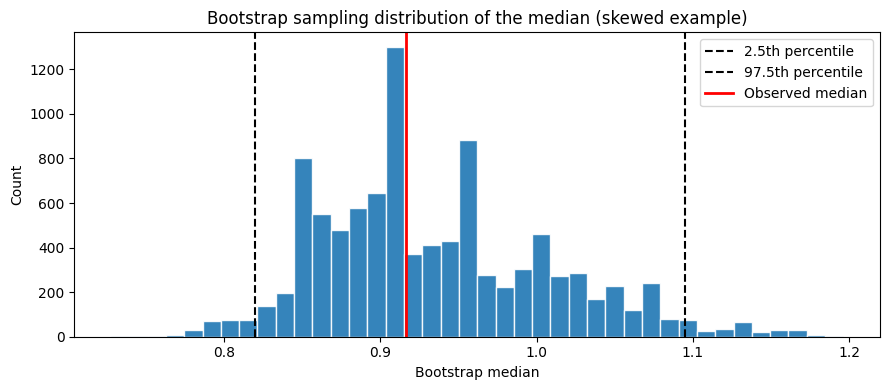

In [2]:
def bootstrap_ci_median(x, *, n_boot=10_000, ci=0.95, random_state=42, batch_size=2_000):
    """Percentile bootstrap confidence interval for the median.

    Parameters
    ----------
    x : array-like
        1D observations.
    n_boot : int
        Number of bootstrap resamples.
    ci : float
        Confidence level in (0, 1), e.g. 0.95.
    random_state : int | None
        Seed for reproducibility.
    batch_size : int
        Compute bootstraps in batches to limit peak memory.

    Returns
    -------
    dict with keys: median, ci_lower, ci_upper, level, n, n_boot
    """
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]  # drop NaN/inf for robustness
    if x.ndim != 1:
        raise ValueError("x must be 1D")
    n = x.size
    if n == 0:
        raise ValueError("x must contain at least one finite value")
    if not (isinstance(n_boot, int) and n_boot > 0):
        raise ValueError("n_boot must be a positive integer")
    if not (0.0 < ci < 1.0):
        raise ValueError("ci must be in (0, 1)")
    if not (isinstance(batch_size, int) and batch_size > 0):
        raise ValueError("batch_size must be a positive integer")

    rng_local = np.random.default_rng(random_state)
    boot_medians = np.empty(n_boot, dtype=float)

    done = 0
    while done < n_boot:
        b = min(batch_size, n_boot - done)
        idx = rng_local.integers(0, n, size=(b, n))
        boot_medians[done : done + b] = np.median(x[idx], axis=1)
        done += b

    alpha = 1.0 - ci
    lower = np.percentile(boot_medians, 100.0 * (alpha / 2.0))
    upper = np.percentile(boot_medians, 100.0 * (1.0 - alpha / 2.0))

    return {
        "median": float(np.median(x)),
        "ci_lower": float(lower),
        "ci_upper": float(upper),
        "level": float(ci),
        "n": int(n),
        "n_boot": int(n_boot),
    }

def bootstrap_medians(x, *, n_boot=10_000, random_state=42, batch_size=2_000):
    """Return the bootstrap sampling distribution of the median (for plotting)."""
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0:
        raise ValueError("x must contain at least one finite value")
    rng_local = np.random.default_rng(random_state)
    out = np.empty(n_boot, dtype=float)
    done = 0
    while done < n_boot:
        b = min(batch_size, n_boot - done)
        idx = rng_local.integers(0, n, size=(b, n))
        out[done : done + b] = np.median(x[idx], axis=1)
        done += b
    return out

# Example 1: small, hand-sized dataset (matches the README narrative)
data_small = np.array([3, 5, 7, 9, 12, 15, 18, 22, 25], dtype=float)
ci_small = bootstrap_ci_median(data_small, n_boot=10_000, ci=0.95, random_state=RANDOM_STATE)
print("Small data CI:", ci_small)

# Example 2: skewed data (lognormal) where median is a natural summary
data_skew = rng.lognormal(mean=0.0, sigma=1.0, size=300)
ci_skew = bootstrap_ci_median(data_skew, n_boot=10_000, ci=0.95, random_state=RANDOM_STATE)
print("\nSkewed data CI:", ci_skew)

# Visualize the bootstrap sampling distribution for the skewed example
boot_med = bootstrap_medians(data_skew, n_boot=10_000, random_state=RANDOM_STATE)
obs_med = np.median(data_skew)

plt.figure(figsize=(9, 4))
plt.hist(boot_med, bins=40, edgecolor="white", alpha=0.9)
plt.axvline(ci_skew["ci_lower"], color="black", linestyle="--", label="2.5th percentile")
plt.axvline(ci_skew["ci_upper"], color="black", linestyle="--", label="97.5th percentile")
plt.axvline(obs_med, color="red", linestyle="-", linewidth=2, label="Observed median")
plt.title("Bootstrap sampling distribution of the median (skewed example)")
plt.xlabel("Bootstrap median")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

## Practical checklist (and common pitfalls)
- **Dependence matters**: if observations are time-series / clustered, i.i.d. bootstrapping can be wrong. Consider block/bootstrap-by-cluster variants.
- **Small $n$**: bootstrap intervals can be unstable with very small samples; report uncertainty and consider more iterations or alternative methods.
- **Ties / discrete data**: many repeated values can make the bootstrap distribution “lumpy” (still OK—just interpret accordingly).
- **Iterations vs. compute**: 1,000 can be OK for quick answers; 10,000 is a common default; more helps stabilize tail percentiles.
- **Data cleaning**: be explicit about how missing/infinite values were handled (here we drop non-finite values).

## Conclusion
When the problem shifts from “mean” to “median,” you don’t need awkward normal approximations. A clean, implementation-ready answer is to **bootstrap**: resample, compute the median repeatedly, and take percentile bounds.

That’s both statistically sensible for skew/outlier-heavy data and exactly the kind of practical reasoning interviewers like to see.